In [1]:
from src.model.eegnet_variance import EEGNetMultiHeaded
from pytorch_lightning.loggers import CometLogger
from src.datamodule import DataModule, predictDataSet
from src.preprocessing import create_dataset
import pytorch_lightning as pl
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from src.preprocessing import *
from src.noise_addition import zero_signal, add_gaussian_noise
import copy
import random
import pickle

In [2]:
comet_logger = CometLogger(
    api_key="WSATCNWE43zphHslQCTsJKcgk",
    workspace="marwo22",  # Optional
    project_name="bachelors-project"  # Optional
)

CometLogger will be initialized in online mode


In [3]:
# Used this method of sampling, since normal sampling will not work when channels are less than 20
def sample_5_percent(n_channels):
    count = 0
    for _ in range(n_channels):
        if random.randint(0, 19) == 0:
            count += 1
    
    return count

In [4]:
# Adds noise to a single EEG windows. Severity influences the severity of the noise
def add_noise_to_eeg(signal, severity: int):
        # Pick random method of adding noise
    random_val = random.randint(0, 2)
        # The amount of channels to add noise to is 10% multiplied by the severity
        # Thus ranging from 10% to 100%
    channels_to_corrupt = int(64 / 10 * severity)


    if random_val == 0: # Gaussian noise
            # Adds Gaussian noise to the entire length of the signal on n_channels. The sd of the noise is 0.25 multiplied by the severity
            # Thus raning from .25 to 2.5
        signal = add_gaussian_noise(signal, .25 * severity, channels_to_corrupt, 0, 308)
    elif random_val == 1: # Zeroing
            # Each channel has a 5% to be completely zeroed
        samples = sample_5_percent(channels_to_corrupt)
            # Add zero datapoints to n_channels. The percentage of datapoints to zero is 3% multiplied by the severity
            # Thus ranging from 3% to 30%
        signal = zero_signal(signal, channels_to_corrupt - samples, percentage=3 * severity)
            # If there are channels to fully zero, zero the signal with 100%
            # Note that this can be a previously partially zeroed channel, but that should not really matter
        if samples:
            signal = zero_signal(signal, samples, percentage=100)
    elif random_val == 2: # Combination of both
            # Add noise to half of the n_channels, and zero the other half
        channels_to_corrupt = int(channels_to_corrupt / 2)
        signal = add_gaussian_noise(signal, .25 * severity, channels_to_corrupt, 0, 308)
        samples = sample_5_percent(channels_to_corrupt)
        signal = zero_signal(signal, channels_to_corrupt - samples, percentage=0.03 * severity)
        if samples:
            signal = zero_signal(signal, samples, percentage=100)

    return signal


In [5]:
# Adds noise to a full training/testing/validation dataset
# Severity_index can be any value from 0 to, and including, 10.
# This index will influence the amount and severity of the noise
def add_noise_to_dataset(dataset, severity_index):
        # No noise is added when severity==0
    if (severity_index == 0):
        return dataset

    length = len(dataset[0])
        # Add noise to 5%  * severityIndex of samples in the dataset. It can thus range from 5% to 50%
    episodes_to_corrupt = random.sample(range(0, length), int(0.05 * length))
        # Add noise to the samples
    for episode in episodes_to_corrupt:
        dataset[0][episode] = add_noise_to_eeg(dataset[0][episode], severity_index)

    return dataset



19712
17068


Text(0.5, 0.98, 'The effect of medium global noise on the first 5 channels')

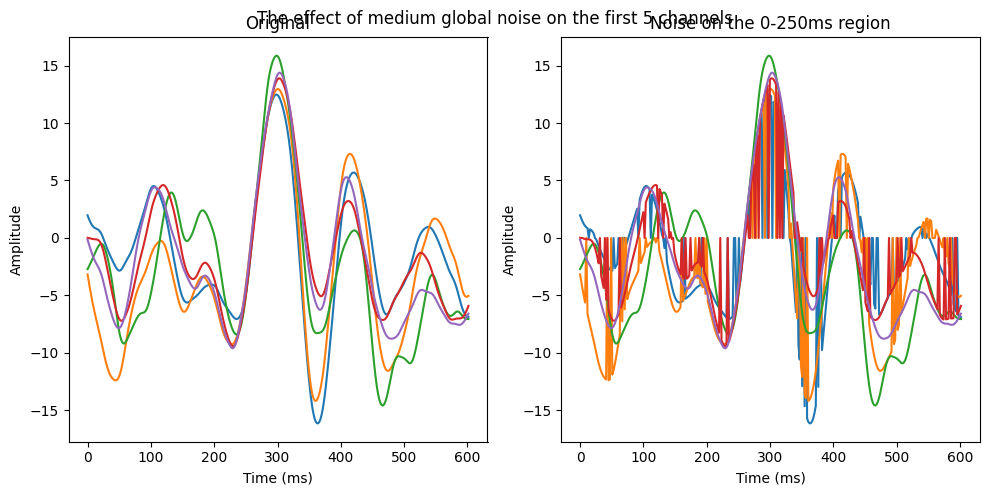

In [16]:
# Plot the first five channels of the first windows of the EEG with added noise
# The noise is of severity_idx 5, resulting in 'medium' noise

# Load training module
train, val, test = create_dataset('./src/pickle_df', 1)

train_copy = copy.deepcopy(train)

corrupted = add_noise_to_eeg(train_copy[0][0], 5)

duration = 308 / 512 * 1000
t = np.linspace(0, duration, 308)

figure, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(t, train[0][0][0], label='1')
axes[0].plot(t, train[0][0][1], label='2')
axes[0].plot(t, train[0][0][2], label="3")
axes[0].plot(t, train[0][0][3], label="4")
axes[0].plot(t, train[0][0][4], label="5")
axes[0].set_xlabel("Time (ms)")
axes[0].set_ylabel("Amplitude")
axes[0].set_title("Original")

axes[1].plot(t, corrupted[0], label='1')
axes[1].plot(t, corrupted[1], label='2')
axes[1].plot(t, corrupted[2], label="3")
axes[1].plot(t, corrupted[3], label="4")
axes[1].plot(t, corrupted[4], label="5")
axes[1].set_xlabel("Time (ms)")
axes[1].set_ylabel("Amplitude")
axes[1].set_title("Noise on the 0-250ms region")

figure.tight_layout()
figure.suptitle("The effect of medium global noise on the first 5 channels")
# Title and subtitle overlap, but its only for visualization

In [40]:
variances = [[] for _ in range(11)]
accuracies = [[] for _ in range(11)]

for j in range(6):
    # Load in the datasets with the current participant as test set
    train, val, test = create_dataset('./src/pickle_df', j + 1)

    # Do 11 runs for each participant. One without noise, and 10 with intensities 1-10
    for i in range(11):
        # Take a deepcopy of the sets
        train_copy = copy.deepcopy(train)
        val_copy = copy.deepcopy(val)
        test_copy = copy.deepcopy(test)

        # Add noise to each set
        train_copy = add_noise_to_dataset(train_copy, i)
        val_copy = add_noise_to_dataset(val_copy, i)
        test_copy = add_noise_to_dataset(test_copy, i)
            
        dm = DataModule(train=train_copy, val=val_copy, test=test_copy, batch_size=16)

        model = EEGNetMultiHeaded(chunk_size=308,
                                num_electrodes=64,
                                dropout=0.5,
                                kernel_1=64,
                                kernel_2=16,
                                F1=8,
                                F2=16,
                                D=2,
                                num_classes=2)
        # Train for 25 epochs. Will probably do 50 for the final results
        trainer = pl.Trainer(
            max_epochs=25,
            logger=comet_logger
        )

        # Fit and test the model
        trainer.fit(model, datamodule=dm)
        test_results = trainer.test(model, datamodule=dm)

        # Save the testing variances and accuracies
        variances[i].append(test_results[0]['overall_var'])
        accuracies[i].append(test_results[0]['test_acc'])

        # Save the variances and accuracies to pkl files
        with open('results_pickled/variances.pkl', 'wb') as f:
            pickle.dump(variances, f)

        with open('results_pickled/accuracies.pkl', 'wb') as f:
            pickle.dump(accuracies, f)
    
    # Just to visualize progress easier, the output is very messy
    print("\n\n\n\n\nFinished" + str(j) + "\n\n\n\n\n")

        

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 24: 100%|██████████| 432/432 [00:05<00:00, 75.50it/s, v_num=8f59]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 432/432 [00:05<00:00, 75.38it/s, v_num=8f59]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10800] : (0.6039618253707886, 51.91114807128906)
COMET INFO:     val_loss [1677]    : (6.073887348175049, 57.2685546875)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (1.25 MB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET INFO: 

Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 76.49it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 27.73it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.2126981608813197     │
│       incorrect_var       │     0.236946748510573     │
│        overall_var        │    0.2158367397099505     │
│         test_acc          │    0.8572797179222107     │
│         test_loss         │    10.594289779663086     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.2126981608813197
COMET INFO:     incorrect_var : 0.236946748510573
COMET INFO:     overall_var   : 0.2158367397099505
COMET INFO:     test_acc      : 0.8572797179222107
COMET INFO:     test_loss     : 10.594289779663086
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True
TPU

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 432/432 [00:05<00:00, 75.96it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 432/432 [00:05<00:00, 75.80it/s, v_num=8f59]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10800] : (0.7321943044662476, 72.51593017578125)


COMET INFO:     val_loss [1677]    : (5.464944839477539, 46.85985565185547)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 51 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 80.01it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 27.51it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.21613818433651094    │
│       incorrect_var       │    0.23679677123751147    │
│        overall_var        │    0.22061735935423565    │
│         test_acc          │     0.795976996421814     │
│         test_loss         │     11.95140266418457     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.21613818433651094
COMET INFO:     incorrect_var : 0.23679677123751147
COMET INFO:     overall_var   : 0.22061735935423565
COMET INFO:     test_acc      : 0.795976996421814
COMET INFO:     test_loss     : 11.95140266418457
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 432/432 [00:05<00:00, 74.84it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 432/432 [00:05<00:00, 74.73it/s, v_num=8f59]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10800] : (0.8128020763397217, 122.99322509765625)
COMET INFO:     val_loss [1677]    : (8.568634986877441, 53.020294189453125)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 51 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 66/66 [00:01<00:00, 59.57it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 25.15it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.22232826915346915    │
│       incorrect_var       │    0.24241519576474815    │
│        overall_var        │    0.22491676406042785    │
│         test_acc          │    0.8601532578468323     │
│         test_loss         │    10.928857803344727     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.22232826915346915
COMET INFO:     incorrect_var : 0.24241519576474815
COMET INFO:     overall_var   : 0.22491676406042785
COMET INFO:     test_acc      : 0.8601532578468323
COMET INFO:     test_loss     : 10.928857803344727
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 432/432 [00:05<00:00, 83.81it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 432/432 [00:05<00:00, 83.65it/s, v_num=8f59]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10800] : (0.8250288367271423, 47.356990814208984)
COMET INFO:     val_loss [1677]    : (5.178504943847656, 47.054603576660156)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 51 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 90.52it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 29.39it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.20767679104350378    │
│       incorrect_var       │    0.2360102593473578     │
│        overall_var        │    0.21201136612629526    │
│         test_acc          │    0.8409961462020874     │
│         test_loss         │    10.692375183105469     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.20767679104350378
COMET INFO:     incorrect_var : 0.2360102593473578
COMET INFO:     overall_var   : 0.21201136612629526
COMET INFO:     test_acc      : 0.8409961462020874
COMET INFO:     test_loss     : 10.692375183105469
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 432/432 [00:05<00:00, 79.70it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 432/432 [00:05<00:00, 79.57it/s, v_num=8f59]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10800] : (0.7334715127944946, 59.174659729003906)
COMET INFO:     val_loss [1677]    : (5.6452107429504395, 49.412635803222656)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 51 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 85.38it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 29.10it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.2076094135016563     │
│       incorrect_var       │    0.2345582691115677     │
│        overall_var        │    0.2110376458443787     │
│         test_acc          │    0.8745210766792297     │
│         test_loss         │    10.050909996032715     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.2076094135016563
COMET INFO:     incorrect_var : 0.2345582691115677
COMET INFO:     overall_var   : 0.2110376458443787
COMET INFO:     test_acc      : 0.8745210766792297
COMET INFO:     test_loss     : 10.050909996032715
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True
TP

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 432/432 [00:05<00:00, 80.62it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 432/432 [00:05<00:00, 80.50it/s, v_num=8f59]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10800] : (0.31292182207107544, 78.38510131835938)
COMET INFO:     val_loss [1677]    : (5.97121524810791, 51.048011779785156)
COMET INFO:   Others:


COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 51 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 89.19it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 29.69it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.2152603143263018     │
│       incorrect_var       │    0.23605457264957122    │
│        overall_var        │    0.21785757821981022    │
│         test_acc          │    0.8687739372253418     │
│         test_loss         │    10.588027954101562     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.2152603143263018
COMET INFO:     incorrect_var : 0.23605457264957122
COMET INFO:     overall_var   : 0.21785757821981022
COMET INFO:     test_acc      : 0.8687739372253418
COMET INFO:     test_loss     : 10.588027954101562
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 432/432 [00:05<00:00, 80.21it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 432/432 [00:05<00:00, 80.07it/s, v_num=8f59]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10800] : (0.7088737487792969, 48.14369201660156)
COMET INFO:     val_loss [1677]    : (5.873662948608398, 52.05133056640625)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 51 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 81.80it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 28.21it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.2121614318885202     │
│       incorrect_var       │    0.23712815836173337    │
│        overall_var        │    0.21532505690708928    │
│         test_acc          │    0.8745210766792297     │
│         test_loss         │    10.237472534179688     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.2121614318885202
COMET INFO:     incorrect_var : 0.23712815836173337
COMET INFO:     overall_var   : 0.21532505690708928
COMET INFO:     test_acc      : 0.8745210766792297
COMET INFO:     test_loss     : 10.237472534179688
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 432/432 [00:05<00:00, 79.34it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 432/432 [00:05<00:00, 79.22it/s, v_num=8f59]

COMET INFO: ---------------------------------------------------------------------------------------


COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10800] : (0.6103923320770264, 56.84602355957031)
COMET INFO:     val_loss [1677]    : (5.767425537109375, 50.32189178466797)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 51 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 87.30it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 29.24it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.19888349103465314    │
│       incorrect_var       │    0.2316232890440022     │
│        overall_var        │    0.20231749537004823    │
│         test_acc          │    0.8955938816070557     │
│         test_loss         │     9.025544166564941     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.19888349103465314
COMET INFO:     incorrect_var : 0.2316232890440022
COMET INFO:     overall_var   : 0.20231749537004823
COMET INFO:     test_acc      : 0.8955938816070557
COMET INFO:     test_loss     : 9.025544166564941
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True
T

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 432/432 [00:05<00:00, 80.52it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 432/432 [00:05<00:00, 80.40it/s, v_num=8f59]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10800] : (0.7386553287506104, 14166.857421875)
COMET INFO:     val_loss [1677]    : (12.699394226074219, 55.52064514160156)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 51 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 81.40it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 28.62it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.24948051375328667    │
│       incorrect_var       │    0.24967796244835078    │
│        overall_var        │    0.24955481183768688    │
│         test_acc          │    0.6336206793785095     │
│         test_loss         │    16.170623779296875     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.24948051375328667
COMET INFO:     incorrect_var : 0.24967796244835078
COMET INFO:     overall_var   : 0.24955481183768688
COMET INFO:     test_acc      : 0.6336206793785095
COMET INFO:     test_loss     : 16.170623779296875
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 432/432 [00:05<00:00, 79.55it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 432/432 [00:05<00:00, 79.42it/s, v_num=8f59]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10800] : (-0.09375995397567749, 96794.7578125)
COMET INFO:     val_loss [1677]    : (-1.6613798141479492, 104.79655456542969)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 51 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 82.93it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 28.54it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.1537147472913915     │
│       incorrect_var       │    0.15334525328862622    │
│        overall_var        │    0.1530614180269141     │
│         test_acc          │    0.7705938816070557     │
│         test_loss         │     18.79422950744629     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.1537147472913915
COMET INFO:     incorrect_var : 0.15334525328862622
COMET INFO:     overall_var   : 0.1530614180269141
COMET INFO:     test_acc      : 0.7705938816070557
COMET INFO:     test_loss     : 18.79422950744629
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True
T

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 432/432 [00:05<00:00, 80.17it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 432/432 [00:05<00:00, 80.05it/s, v_num=8f59]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10800] : (0.6382816433906555, 47.36490249633789)
COMET INFO:     val_loss [1677]    : (5.596438407897949, 48.05985641479492)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 51 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 92.94it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 28.60it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.2132737394128913     │
│       incorrect_var       │    0.23701787846239786    │
│        overall_var        │    0.21660452292539836    │
│         test_acc          │    0.8582375645637512     │
│         test_loss         │    10.818198204040527     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.2132737394128913
COMET INFO:     incorrect_var : 0.23701787846239786
COMET INFO:     overall_var   : 0.21660452292539836
COMET INFO:     test_acc      : 0.8582375645637512
COMET INFO:     test_loss     : 10.818198204040527
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages







Finished0







GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory c:\Users\marti_wfv2bf9\Desktop\Bachelors-project\bachelors-project\d7a05243d8b74db4b767f9302a1a8f59\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 79.19it/s, v_num=8f59]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 79.06it/s, v_num=8f59]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10700] : (4.203273773193359, 67.27204895019531)


COMET INFO:     val_loss [1702]    : (4.632412433624268, 51.181922912597656)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 68/68 [00:00<00:00, 92.02it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 68/68 [00:02<00:00, 30.66it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.2206156428073489     │
│       incorrect_var       │    0.23360441074182528    │
│        overall_var        │    0.22468496180932832    │
│         test_acc          │    0.7074074149131775     │
│         test_loss         │    14.025043487548828     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.2206156428073489
COMET INFO:     incorrect_var : 0.23360441074182528
COMET INFO:     overall_var   : 0.22468496180932832
COMET INFO:     test_acc      : 0.7074074149131775
COMET INFO:     test_loss     : 14.025043487548828
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 79.34it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 79.21it/s, v_num=8f59]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------


COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10700] : (4.715724945068359, 62.26982116699219)
COMET INFO:     val_loss [1702]    : (4.321509838104248, 50.24068069458008)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 68/68 [00:00<00:00, 95.63it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 68/68 [00:02<00:00, 30.26it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.20729832626621922    │
│       incorrect_var       │    0.22077841201216264    │
│        overall_var        │    0.21267300379910956    │
│         test_acc          │    0.6342592835426331     │
│         test_loss         │     16.39991569519043     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.20729832626621922
COMET INFO:     incorrect_var : 0.22077841201216264
COMET INFO:     overall_var   : 0.21267300379910956
COMET INFO:     test_acc      : 0.6342592835426331
COMET INFO:     test_loss     : 16.39991569519043
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 78.69it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 78.56it/s, v_num=8f59]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10700] : (4.128116607666016, 46.37504577636719)
COMET INFO:     val_loss [1702]    : (4.894081115722656, 50.90951156616211)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 68/68 [00:00<00:00, 94.74it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 68/68 [00:02<00:00, 30.67it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.21340380226857156    │
│       incorrect_var       │    0.23232270966492077    │
│        overall_var        │    0.21770658132930595    │
│         test_acc          │    0.7666666507720947     │
│         test_loss         │    12.753585815429688     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.21340380226857156
COMET INFO:     incorrect_var : 0.23232270966492077
COMET INFO:     overall_var   : 0.21770658132930595
COMET INFO:     test_acc      : 0.7666666507720947
COMET INFO:     test_loss     : 12.753585815429688
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: Tru

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 80.14it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 80.00it/s, v_num=8f59]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59


COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10700] : (4.430392265319824, 69.6973876953125)
COMET INFO:     val_loss [1702]    : (3.6078743934631348, 52.55781173706055)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 68/68 [00:00<00:00, 94.96it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 68/68 [00:02<00:00, 30.88it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.20937583041844254    │
│       incorrect_var       │     0.231902759947384     │
│        overall_var        │    0.21368571437757325    │
│         test_acc          │    0.8027777671813965     │
│         test_loss         │    11.677022933959961     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.20937583041844254
COMET INFO:     incorrect_var : 0.231902759947384
COMET INFO:     overall_var   : 0.21368571437757325
COMET INFO:     test_acc      : 0.8027777671813965
COMET INFO:     test_loss     : 11.677022933959961
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 79.59it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 79.45it/s, v_num=8f59]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10700] : (6.120290756225586, 69.77290344238281)
COMET INFO:     val_loss [1702]    : (5.596758842468262, 48.36284637451172)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 68/68 [00:00<00:00, 86.70it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 68/68 [00:02<00:00, 29.84it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.24817197609137132    │
│       incorrect_var       │    0.24843134315035056    │
│        overall_var        │    0.2483259524460192     │
│         test_acc          │    0.4055555462837219     │
│         test_loss         │    16.906789779663086     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.24817197609137132
COMET INFO:     incorrect_var : 0.24843134315035056
COMET INFO:     overall_var   : 0.2483259524460192
COMET INFO:     test_acc      : 0.4055555462837219
COMET INFO:     test_loss     : 16.906789779663086
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 79.31it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 79.19it/s, v_num=8f59]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10700] : (5.45603609085083, 142.70797729492188)
COMET INFO:     val_loss [1702]    : (6.380739688873291, 50.75584411621094)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 68/68 [00:00<00:00, 82.95it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 68/68 [00:02<00:00, 29.45it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.2259550025501038     │
│       incorrect_var       │    0.23717313692385422    │
│        overall_var        │    0.22915788835121526    │
│         test_acc          │     0.710185170173645     │
│         test_loss         │     14.1248779296875      │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.2259550025501038
COMET INFO:     incorrect_var : 0.23717313692385422
COMET INFO:     overall_var   : 0.22915788835121526
COMET INFO:     test_acc      : 0.710185170173645
COMET INFO:     test_loss     : 14.1248779296875
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True
TP

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 79.11it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 78.96it/s, v_num=8f59]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10700] : (3.9964818954467773, 51.60805892944336)


COMET INFO:     val_loss [1702]    : (3.2348246574401855, 48.74748992919922)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 68/68 [00:00<00:00, 94.70it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 68/68 [00:02<00:00, 30.50it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.1898375747193272     │
│       incorrect_var       │    0.2261933096801187     │
│        overall_var        │    0.1963246364801846     │
│         test_acc          │    0.8259259462356567     │
│         test_loss         │     10.39564323425293     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.1898375747193272
COMET INFO:     incorrect_var : 0.2261933096801187
COMET INFO:     overall_var   : 0.1963246364801846
COMET INFO:     test_acc      : 0.8259259462356567
COMET INFO:     test_loss     : 10.39564323425293
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True
TP

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 79.10it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 78.97it/s, v_num=8f59]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10700] : (4.936618804931641, 42.693904876708984)
COMET INFO:     val_loss [1702]    : (3.4506289958953857, 85.88260650634766)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 68/68 [00:00<00:00, 93.02it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 68/68 [00:02<00:00, 30.43it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.21770458204103482    │
│       incorrect_var       │    0.23263495887301597    │
│        overall_var        │    0.22221770877087557    │
│         test_acc          │    0.7037037014961243     │
│         test_loss         │    14.155369758605957     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.21770458204103482
COMET INFO:     incorrect_var : 0.23263495887301597
COMET INFO:     overall_var   : 0.22221770877087557
COMET INFO:     test_acc      : 0.7037037014961243
COMET INFO:     test_loss     : 14.155369758605957
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 79.41it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 79.27it/s, v_num=8f59]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10700] : (3.2785186767578125, 50.44606018066406)
COMET INFO:     val_loss [1702]    : (4.701171398162842, 49.87071228027344)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 68/68 [00:00<00:00, 91.97it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 68/68 [00:02<00:00, 30.07it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.21507808827294794    │
│       incorrect_var       │    0.23223049549754135    │
│        overall_var        │     0.21905432353831      │
│         test_acc          │    0.7555555701255798     │
│         test_loss         │     12.95548152923584     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.21507808827294794
COMET INFO:     incorrect_var : 0.23223049549754135
COMET INFO:     overall_var   : 0.21905432353831
COMET INFO:     test_acc      : 0.7555555701255798
COMET INFO:     test_loss     : 12.95548152923584
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True
TP

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 79.15it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 79.01it/s, v_num=8f59]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------


COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10700] : (6.1847076416015625, 27636.900390625)
COMET INFO:     val_loss [1702]    : (11.146410942077637, 52.11906433105469)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 68/68 [00:00<00:00, 94.30it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 68/68 [00:02<00:00, 30.56it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.2063999827294426     │
│       incorrect_var       │    0.2058591498069627     │
│        overall_var        │    0.20588495732733497    │
│         test_acc          │    0.2240740805864334     │
│         test_loss         │    30.833904266357422     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.2063999827294426
COMET INFO:     incorrect_var : 0.2058591498069627
COMET INFO:     overall_var   : 0.20588495732733497
COMET INFO:     test_acc      : 0.2240740805864334
COMET INFO:     test_loss     : 30.833904266357422
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 77.46it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 77.31it/s, v_num=8f59]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10700] : (4.657304763793945, 67.17007446289062)
COMET INFO:     val_loss [1702]    : (5.308279037475586, 47.202640533447266)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 68/68 [00:00<00:00, 89.15it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 68/68 [00:02<00:00, 29.80it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.21707613818800894    │
│       incorrect_var       │    0.23463829779829934    │
│        overall_var        │    0.22126665498923373    │
│         test_acc          │    0.7546296119689941     │
│         test_loss         │    12.930184364318848     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.21707613818800894
COMET INFO:     incorrect_var : 0.23463829779829934
COMET INFO:     overall_var   : 0.22126665498923373
COMET INFO:     test_acc      : 0.7546296119689941
COMET INFO:     test_loss     : 12.930184364318848
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages







Finished1







GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory c:\Users\marti_wfv2bf9\Desktop\Bachelors-project\bachelors-project\d7a05243d8b74db4b767f9302a1a8f59\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 77.22it/s, v_num=8f59]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 77.09it/s, v_num=8f59]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10700] : (2.1942925453186035, 182.05735778808594)
COMET INFO:     val_loss [1727]    : (4.813429832458496, 46.894737243652344)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 65/65 [00:00<00:00, 85.87it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 65/65 [00:02<00:00, 28.74it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.24813874837265212    │
│       incorrect_var       │    0.24864382101721572    │
│        overall_var        │    0.24833571663464357    │
│         test_acc          │    0.6167953610420227     │
│         test_loss         │    16.128427505493164     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.24813874837265212
COMET INFO:     incorrect_var : 0.24864382101721572
COMET INFO:     overall_var   : 0.24833571663464357
COMET INFO:     test_acc      : 0.6167953610420227
COMET INFO:     test_loss     : 16.128427505493164
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: Tru

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 78.93it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 78.79it/s, v_num=8f59]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):


COMET INFO:     train_loss [10700] : (2.1667041778564453, 48.28821563720703)
COMET INFO:     val_loss [1727]    : (3.957108497619629, 47.87119674682617)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 65/65 [00:00<00:00, 90.65it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 65/65 [00:02<00:00, 29.54it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.20763803736124015    │
│       incorrect_var       │    0.21872038966971832    │
│        overall_var        │    0.21120773111272273    │
│         test_acc          │    0.6911196708679199     │
│         test_loss         │    15.645488739013672     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.20763803736124015
COMET INFO:     incorrect_var : 0.21872038966971832
COMET INFO:     overall_var   : 0.21120773111272273
COMET INFO:     test_acc      : 0.6911196708679199
COMET INFO:     test_loss     : 15.645488739013672
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 78.32it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 78.18it/s, v_num=8f59]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------


COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10700] : (1.6425424814224243, 65.97953796386719)
COMET INFO:     val_loss [1727]    : (3.686976432800293, 48.6083984375)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 65/65 [00:00<00:00, 88.55it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 65/65 [00:02<00:00, 28.51it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.20684470300173255    │
│       incorrect_var       │    0.21918219653142096    │
│        overall_var        │    0.2116938456065924     │
│         test_acc          │    0.6148648858070374     │
│         test_loss         │    17.337467193603516     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.20684470300173255
COMET INFO:     incorrect_var : 0.21918219653142096
COMET INFO:     overall_var   : 0.2116938456065924
COMET INFO:     test_acc      : 0.6148648858070374
COMET INFO:     test_loss     : 17.337467193603516
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 79.02it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 78.87it/s, v_num=8f59]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:


COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10700] : (1.090562343597412, 27630.470703125)
COMET INFO:     val_loss [1727]    : (4.1847734451293945, 56.506141662597656)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 65/65 [00:00<00:00, 94.32it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 65/65 [00:02<00:00, 30.01it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.18471143074593468    │
│       incorrect_var       │    0.18487518395718985    │
│        overall_var        │    0.18474743966890578    │
│         test_acc          │    0.8185328245162964     │
│         test_loss         │    12.220423698425293     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.18471143074593468
COMET INFO:     incorrect_var : 0.18487518395718985
COMET INFO:     overall_var   : 0.18474743966890578
COMET INFO:     test_acc      : 0.8185328245162964
COMET INFO:     test_loss     : 12.220423698425293
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 78.52it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 78.39it/s, v_num=8f59]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10700] : (1.004010796546936, 48.97102355957031)
COMET INFO:     val_loss [1727]    : (5.2391510009765625, 50.7514533996582)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 65/65 [00:00<00:00, 81.67it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 65/65 [00:02<00:00, 28.03it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.21206736021045744    │
│       incorrect_var       │    0.2216754817050449     │
│        overall_var        │    0.21484998886700016    │
│         test_acc          │    0.7239382266998291     │
│         test_loss         │     14.94762897491455     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.21206736021045744
COMET INFO:     incorrect_var : 0.2216754817050449
COMET INFO:     overall_var   : 0.21484998886700016
COMET INFO:     test_acc      : 0.7239382266998291
COMET INFO:     test_loss     : 14.94762897491455
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True
T

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 79.45it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 79.31it/s, v_num=8f59]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10700] : (1.2622640132904053, 69.89629364013672)
COMET INFO:     val_loss [1727]    : (4.661738395690918, 53.405399322509766)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 65/65 [00:00<00:00, 81.98it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 65/65 [00:02<00:00, 28.80it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.20677425409457573    │
│       incorrect_var       │    0.21745182024835802    │
│        overall_var        │    0.2108926457428449     │
│         test_acc          │    0.6245173811912537     │
│         test_loss         │    17.394073486328125     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.20677425409457573
COMET INFO:     incorrect_var : 0.21745182024835802
COMET INFO:     overall_var   : 0.2108926457428449
COMET INFO:     test_acc      : 0.6245173811912537
COMET INFO:     test_loss     : 17.394073486328125
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 78.69it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 78.55it/s, v_num=8f59]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10700] : (2.70308256149292, 27710.7890625)
COMET INFO:     val_loss [1727]    : (4.420586109161377, 61.6807861328125)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning


COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 65/65 [00:00<00:00, 94.05it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 65/65 [00:02<00:00, 29.94it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.24677454883240477    │
│       incorrect_var       │    0.24888621900583838    │
│        overall_var        │    0.2473170292711166     │
│         test_acc          │    0.7302123308181763     │
│         test_loss         │    15.040298461914062     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.24677454883240477
COMET INFO:     incorrect_var : 0.24888621900583838
COMET INFO:     overall_var   : 0.2473170292711166
COMET INFO:     test_acc      : 0.7302123308181763
COMET INFO:     test_loss     : 15.040298461914062
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 78.91it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 78.76it/s, v_num=8f59]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10700] : (3.118183135986328, 13829.9306640625)
COMET INFO:     val_loss [1727]    : (12.335992813110352, 58.174068450927734)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 65/65 [00:00<00:00, 93.16it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 65/65 [00:02<00:00, 29.31it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.24699379323744308    │
│       incorrect_var       │    0.24735844989478611    │
│        overall_var        │    0.24730500873739195    │
│         test_acc          │    0.1882239431142807     │
│         test_loss         │     18.8791446685791      │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.24699379323744308
COMET INFO:     incorrect_var : 0.24735844989478611
COMET INFO:     overall_var   : 0.24730500873739195
COMET INFO:     test_acc      : 0.1882239431142807
COMET INFO:     test_loss     : 18.8791446685791
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True
T

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 78.24it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 78.11it/s, v_num=8f59]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10700] : (1.2686898708343506, 56.433685302734375)
COMET INFO:     val_loss [1727]    : (4.518331527709961, 51.010215759277344)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 65/65 [00:00<00:00, 86.49it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 65/65 [00:02<00:00, 29.05it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.22230034562376935    │
│       incorrect_var       │    0.22838889902100964    │
│        overall_var        │    0.22443781521272016    │
│         test_acc          │    0.6332046389579773     │
│         test_loss         │     16.42874526977539     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.22230034562376935
COMET INFO:     incorrect_var : 0.22838889902100964
COMET INFO:     overall_var   : 0.22443781521272016
COMET INFO:     test_acc      : 0.6332046389579773
COMET INFO:     test_loss     : 16.42874526977539
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 79.32it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 79.16it/s, v_num=8f59]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10700] : (1.3004724979400635, 58.575069427490234)
COMET INFO:     val_loss [1727]    : (3.5745861530303955, 50.19377136230469)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 65/65 [00:00<00:00, 89.28it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 65/65 [00:02<00:00, 29.25it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.21098953380210897    │
│       incorrect_var       │    0.2288099230078626     │
│        overall_var        │    0.21459413588075793    │
│         test_acc          │    0.7915058135986328     │
│         test_loss         │    12.434906005859375     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.21098953380210897
COMET INFO:     incorrect_var : 0.2288099230078626
COMET INFO:     overall_var   : 0.21459413588075793
COMET INFO:     test_acc      : 0.7915058135986328
COMET INFO:     test_loss     : 12.434906005859375
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 78.60it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 78.46it/s, v_num=8f59]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10700] : (1.1009526252746582, 50.89482498168945)
COMET INFO:     val_loss [1727]    : (5.307928562164307, 56.610862731933594)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 65/65 [00:00<00:00, 91.79it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 65/65 [00:02<00:00, 29.50it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.22247070738893843    │
│       incorrect_var       │    0.23602657038676225    │
│        overall_var        │    0.22497855128296093    │
│         test_acc          │     0.796332061290741     │
│         test_loss         │     12.72929573059082     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.22247070738893843
COMET INFO:     incorrect_var : 0.23602657038676225
COMET INFO:     overall_var   : 0.22497855128296093
COMET INFO:     test_acc      : 0.796332061290741
COMET INFO:     test_loss     : 12.72929573059082
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages







Finished2







GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory c:\Users\marti_wfv2bf9\Desktop\Bachelors-project\bachelors-project\d7a05243d8b74db4b767f9302a1a8f59\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 78.72it/s, v_num=8f59]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 78.58it/s, v_num=8f59]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------


COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10700] : (3.7541582584381104, 50.83000564575195)
COMET INFO:     val_loss [1727]    : (0.46805986762046814, 50.092594146728516)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is th

Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 88.12it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 28.92it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.20235780344435156    │
│       incorrect_var       │    0.22343169524685622    │
│        overall_var        │     0.206718847955871     │
│         test_acc          │    0.7870722413063049     │
│         test_loss         │    12.042985916137695     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.20235780344435156
COMET INFO:     incorrect_var : 0.22343169524685622
COMET INFO:     overall_var   : 0.206718847955871
COMET INFO:     test_acc      : 0.7870722413063049
COMET INFO:     test_loss     : 12.042985916137695
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True
T

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 78.68it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 78.52it/s, v_num=8f59]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10700] : (3.501667022705078, 52.30381774902344)
COMET INFO:     val_loss [1727]    : (0.5500231981277466, 48.46210479736328)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 93.21it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 28.77it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.17965950843046755    │
│       incorrect_var       │    0.21765740862250782    │
│        overall_var        │    0.18695631816969058    │
│         test_acc          │    0.8070341944694519     │
│         test_loss         │    10.840943336486816     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.17965950843046755
COMET INFO:     incorrect_var : 0.21765740862250782
COMET INFO:     overall_var   : 0.18695631816969058
COMET INFO:     test_acc      : 0.8070341944694519
COMET INFO:     test_loss     : 10.840943336486816
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: Tru

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 77.77it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 77.63it/s, v_num=8f59]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10700] : (2.246613025665283, 52.12220001220703)
COMET INFO:     val_loss [1727]    : (0.3767525553703308, 52.786155700683594)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 93.60it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 29.53it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.19114357897385525    │
│       incorrect_var       │    0.21724348067778163    │
│        overall_var        │    0.1961576278417056     │
│         test_acc          │    0.8203421831130981     │
│         test_loss         │    11.143929481506348     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.19114357897385525
COMET INFO:     incorrect_var : 0.21724348067778163
COMET INFO:     overall_var   : 0.1961576278417056
COMET INFO:     test_acc      : 0.8203421831130981
COMET INFO:     test_loss     : 11.143929481506348
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 77.72it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 77.54it/s, v_num=8f59]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10700] : (3.137970447540283, 62.70378112792969)
COMET INFO:     val_loss [1727]    : (0.4271990656852722, 50.83909606933594)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 91.91it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 30.11it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.24028472536381712    │
│       incorrect_var       │    0.24353312490551451    │
│        overall_var        │    0.24112143497843253    │
│         test_acc          │    0.7471482753753662     │
│         test_loss         │    14.405684471130371     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.24028472536381712
COMET INFO:     incorrect_var : 0.24353312490551451
COMET INFO:     overall_var   : 0.24112143497843253
COMET INFO:     test_acc      : 0.7471482753753662
COMET INFO:     test_loss     : 14.405684471130371
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 78.40it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 78.26it/s, v_num=8f59]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10700] : (3.27836275100708, 61.34083557128906)


COMET INFO:     val_loss [1727]    : (0.5148838758468628, 55.03727340698242)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 92.94it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 29.59it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.2141332373641628     │
│       incorrect_var       │    0.23065786075551395    │
│        overall_var        │    0.21860168962084295    │
│         test_acc          │    0.7024714946746826     │
│         test_loss         │    14.211637496948242     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.2141332373641628
COMET INFO:     incorrect_var : 0.23065786075551395
COMET INFO:     overall_var   : 0.21860168962084295
COMET INFO:     test_acc      : 0.7024714946746826
COMET INFO:     test_loss     : 14.211637496948242
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 428/428 [00:04<00:00, 88.95it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 428/428 [00:04<00:00, 88.81it/s, v_num=8f59]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10700] : (3.294285535812378, 50.705421447753906)
COMET INFO:     val_loss [1727]    : (0.4514563977718353, 43.594329833984375)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 89.79it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 29.52it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.19937027821341666    │
│       incorrect_var       │    0.21856644613388318    │
│        overall_var        │    0.20388225034700827    │
│         test_acc          │    0.7747148275375366     │
│         test_loss         │    12.649727821350098     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.19937027821341666
COMET INFO:     incorrect_var : 0.21856644613388318
COMET INFO:     overall_var   : 0.20388225034700827
COMET INFO:     test_acc      : 0.7747148275375366
COMET INFO:     test_loss     : 12.649727821350098
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: Tru

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 428/428 [00:04<00:00, 89.22it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 428/428 [00:04<00:00, 89.06it/s, v_num=8f59]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10700] : (2.440164566040039, 51.56779098510742)
COMET INFO:     val_loss [1727]    : (0.3343311548233032, 52.83031463623047)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning


COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 102.28it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 30.94it/s] 


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.1874719050057056     │
│       incorrect_var       │    0.21994210805584347    │
│        overall_var        │    0.1939009203798644     │
│         test_acc          │    0.8060836791992188     │
│         test_loss         │    11.088531494140625     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.1874719050057056
COMET INFO:     incorrect_var : 0.21994210805584347
COMET INFO:     overall_var   : 0.1939009203798644
COMET INFO:     test_acc      : 0.8060836791992188
COMET INFO:     test_loss     : 11.088531494140625
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 80.82it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 428/428 [00:05<00:00, 80.66it/s, v_num=8f59]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):


COMET INFO:     train_loss [10700] : (4.03206729888916, 54.838722229003906)
COMET INFO:     val_loss [1727]    : (0.15581971406936646, 48.826324462890625)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 93.34it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 30.05it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.20333947196722857    │
│       incorrect_var       │     0.223386362475011     │
│        overall_var        │    0.20758698668203426    │
│         test_acc          │    0.7851710915565491     │
│         test_loss         │    12.202765464782715     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.20333947196722857
COMET INFO:     incorrect_var : 0.223386362475011
COMET INFO:     overall_var   : 0.20758698668203426
COMET INFO:     test_acc      : 0.7851710915565491
COMET INFO:     test_loss     : 12.202765464782715
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 428/428 [00:04<00:00, 87.78it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 428/428 [00:04<00:00, 87.60it/s, v_num=8f59]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10700] : (2.445858955383301, 49.63270950317383)
COMET INFO:     val_loss [1727]    : (0.3837684392929077, 53.20957565307617)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 92.94it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 29.06it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.19511823391450164    │
│       incorrect_var       │     0.21684542690582      │
│        overall_var        │     0.198824840636761     │
│         test_acc          │    0.8374524712562561     │
│         test_loss         │    10.903741836547852     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.19511823391450164
COMET INFO:     incorrect_var : 0.21684542690582
COMET INFO:     overall_var   : 0.198824840636761
COMET INFO:     test_acc      : 0.8374524712562561
COMET INFO:     test_loss     : 10.903741836547852
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True
TPU 

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 428/428 [00:04<00:00, 87.73it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 428/428 [00:04<00:00, 87.57it/s, v_num=8f59]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10700] : (3.5386295318603516, 50.712406158447266)
COMET INFO:     val_loss [1727]    : (0.23579028248786926, 49.26810073852539)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 96.95it/s] 

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 29.95it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.19311942535461377    │
│       incorrect_var       │    0.22006516084228017    │
│        overall_var        │    0.19814558286828912    │
│         test_acc          │    0.8070341944694519     │
│         test_loss         │    11.514772415161133     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.19311942535461377
COMET INFO:     incorrect_var : 0.22006516084228017
COMET INFO:     overall_var   : 0.19814558286828912
COMET INFO:     test_acc      : 0.8070341944694519
COMET INFO:     test_loss     : 11.514772415161133
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: Tru

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 428/428 [00:04<00:00, 87.63it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 428/428 [00:04<00:00, 87.47it/s, v_num=8f59]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10700] : (2.3459692001342773, 51.17723846435547)
COMET INFO:     val_loss [1727]    : (0.5156171321868896, 52.145347595214844)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 1 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 100.64it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 30.74it/s] 


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.1901187361472263     │
│       incorrect_var       │    0.21498705126231463    │
│        overall_var        │    0.19493051702617012    │
│         test_acc          │    0.8070341944694519     │
│         test_loss         │     11.46866226196289     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.1901187361472263
COMET INFO:     incorrect_var : 0.21498705126231463
COMET INFO:     overall_var   : 0.19493051702617012
COMET INFO:     test_acc      : 0.8070341944694519
COMET INFO:     test_loss     : 11.46866226196289
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages







Finished3







GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory c:\Users\marti_wfv2bf9\Desktop\Bachelors-project\bachelors-project\d7a05243d8b74db4b767f9302a1a8f59\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 24: 100%|██████████| 427/427 [00:04<00:00, 88.65it/s, v_num=8f59]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 427/427 [00:04<00:00, 88.52it/s, v_num=8f59]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10675] : (4.982176780700684, 53.24496841430664)
COMET INFO:     val_loss [1652]    : (4.865206718444824, 54.293548583984375)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 285 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 71/71 [00:00<00:00, 85.77it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 71/71 [00:02<00:00, 30.67it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.19491205015137142    │
│       incorrect_var       │    0.22789534238351655    │
│        overall_var        │    0.19914856092641106    │
│         test_acc          │    0.8682101368904114     │
│         test_loss         │     9.595808982849121     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.19491205015137142
COMET INFO:     incorrect_var : 0.22789534238351655
COMET INFO:     overall_var   : 0.19914856092641106
COMET INFO:     test_acc      : 0.8682101368904114
COMET INFO:     test_loss     : 9.595808982849121
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 427/427 [00:04<00:00, 88.38it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 427/427 [00:04<00:00, 88.25it/s, v_num=8f59]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10675] : (4.947465896606445, 49.752296447753906)
COMET INFO:     val_loss [1652]    : (3.682603359222412, 52.389137268066406)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 284 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 71/71 [00:00<00:00, 85.67it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 71/71 [00:02<00:00, 30.67it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.1836422595079707     │
│       incorrect_var       │    0.22327104564269748    │
│        overall_var        │    0.18838426876955816    │
│         test_acc          │     0.871772050857544     │
│         test_loss         │     9.032014846801758     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.1836422595079707
COMET INFO:     incorrect_var : 0.22327104564269748
COMET INFO:     overall_var   : 0.18838426876955816
COMET INFO:     test_acc      : 0.871772050857544
COMET INFO:     test_loss     : 9.032014846801758
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True
T

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 427/427 [00:04<00:00, 88.95it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 427/427 [00:04<00:00, 88.82it/s, v_num=8f59]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):


COMET INFO:     train_loss [10675] : (5.3840107917785645, 80.82389831542969)
COMET INFO:     val_loss [1652]    : (4.41392707824707, 38.671016693115234)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 284 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 71/71 [00:00<00:00, 100.13it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 71/71 [00:02<00:00, 32.05it/s] 


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.20573327493035798    │
│       incorrect_var       │    0.23147165974809064    │
│        overall_var        │    0.2095689748116136     │
│         test_acc          │     0.845948338508606     │
│         test_loss         │     10.68405532836914     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.20573327493035798
COMET INFO:     incorrect_var : 0.23147165974809064
COMET INFO:     overall_var   : 0.2095689748116136
COMET INFO:     test_acc      : 0.845948338508606
COMET INFO:     test_loss     : 10.68405532836914
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True
TP

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 427/427 [00:04<00:00, 89.14it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 427/427 [00:04<00:00, 89.01it/s, v_num=8f59]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10675] : (4.252486228942871, 47.5798225402832)
COMET INFO:     val_loss [1652]    : (3.1869730949401855, 71.65655517578125)


COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 284 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 71/71 [00:00<00:00, 98.46it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 71/71 [00:02<00:00, 31.43it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.18327763229479824    │
│       incorrect_var       │    0.2261412028518934     │
│        overall_var        │    0.1890355754885839     │
│         test_acc          │    0.8593054413795471     │
│         test_loss         │     9.24359130859375      │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.18327763229479824
COMET INFO:     incorrect_var : 0.2261412028518934
COMET INFO:     overall_var   : 0.1890355754885839
COMET INFO:     test_acc      : 0.8593054413795471
COMET INFO:     test_loss     : 9.24359130859375
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True
TP

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 427/427 [00:04<00:00, 89.34it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 427/427 [00:04<00:00, 89.21it/s, v_num=8f59]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10675] : (4.388123512268066, 68.62205505371094)
COMET INFO:     val_loss [1652]    : (4.272616386413574, 51.58909606933594)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 284 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 71/71 [00:00<00:00, 86.92it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 71/71 [00:02<00:00, 30.41it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.19614402083105908    │
│       incorrect_var       │    0.22880860228860192    │
│        overall_var        │    0.2010936975903736     │
│         test_acc          │    0.8486197590827942     │
│         test_loss         │    10.169862747192383     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.19614402083105908
COMET INFO:     incorrect_var : 0.22880860228860192
COMET INFO:     overall_var   : 0.2010936975903736
COMET INFO:     test_acc      : 0.8486197590827942
COMET INFO:     test_loss     : 10.169862747192383
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 427/427 [00:04<00:00, 88.40it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 427/427 [00:04<00:00, 88.28it/s, v_num=8f59]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):


COMET INFO:     train_loss [10675] : (5.027830123901367, 45.14659881591797)
COMET INFO:     val_loss [1652]    : (3.8362982273101807, 43.232872009277344)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 284 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 71/71 [00:00<00:00, 88.43it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 71/71 [00:02<00:00, 30.27it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.17323289136454972    │
│       incorrect_var       │    0.2226932404733403     │
│        overall_var        │    0.17964897237764546    │
│         test_acc          │    0.8637577891349792     │
│         test_loss         │     8.815652847290039     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.17323289136454972
COMET INFO:     incorrect_var : 0.2226932404733403
COMET INFO:     overall_var   : 0.17964897237764546
COMET INFO:     test_acc      : 0.8637577891349792
COMET INFO:     test_loss     : 8.815652847290039
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True
T

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 427/427 [00:04<00:00, 86.95it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 427/427 [00:04<00:00, 86.82it/s, v_num=8f59]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10675] : (3.916525363922119, 47.92292785644531)
COMET INFO:     val_loss [1652]    : (3.3730831146240234, 42.67631530761719)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 284 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 71/71 [00:00<00:00, 99.01it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 71/71 [00:02<00:00, 31.70it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.19727178103653456    │
│       incorrect_var       │    0.22933572075305844    │
│        overall_var        │    0.2022948306740551     │
│         test_acc          │    0.8379340767860413     │
│         test_loss         │    10.384236335754395     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.19727178103653456
COMET INFO:     incorrect_var : 0.22933572075305844
COMET INFO:     overall_var   : 0.2022948306740551
COMET INFO:     test_acc      : 0.8379340767860413
COMET INFO:     test_loss     : 10.384236335754395
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 427/427 [00:04<00:00, 88.92it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 427/427 [00:04<00:00, 88.79it/s, v_num=8f59]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10675] : (5.120004177093506, 58.19426727294922)
COMET INFO:     val_loss [1652]    : (3.6557135581970215, 49.905426025390625)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 284 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 71/71 [00:00<00:00, 90.34it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 71/71 [00:02<00:00, 31.46it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.22742929667731296    │
│       incorrect_var       │    0.24017321577922313    │
│        overall_var        │    0.22986169026721723    │
│         test_acc          │    0.8058770895004272     │
│         test_loss         │    12.568119049072266     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.22742929667731296
COMET INFO:     incorrect_var : 0.24017321577922313
COMET INFO:     overall_var   : 0.22986169026721723
COMET INFO:     test_acc      : 0.8058770895004272
COMET INFO:     test_loss     : 12.568119049072266
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 427/427 [00:04<00:00, 88.38it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 427/427 [00:04<00:00, 88.25it/s, v_num=8f59]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10675] : (5.082828044891357, 46.95117950439453)
COMET INFO:     val_loss [1652]    : (5.495152473449707, 54.000709533691406)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 284 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 71/71 [00:00<00:00, 96.46it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 71/71 [00:02<00:00, 31.55it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.2102563933571473     │
│       incorrect_var       │    0.23522071314927862    │
│        overall_var        │    0.21415934132499984    │
│         test_acc          │    0.8388245701789856     │
│         test_loss         │    10.756120681762695     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.2102563933571473
COMET INFO:     incorrect_var : 0.23522071314927862
COMET INFO:     overall_var   : 0.21415934132499984
COMET INFO:     test_acc      : 0.8388245701789856
COMET INFO:     test_loss     : 10.756120681762695
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 427/427 [00:04<00:00, 88.54it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 427/427 [00:04<00:00, 88.39it/s, v_num=8f59]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10675] : (5.436169624328613, 84.6345443725586)
COMET INFO:     val_loss [1652]    : (4.064455509185791, 49.340877532958984)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 284 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 71/71 [00:00<00:00, 95.03it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 71/71 [00:02<00:00, 31.47it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.2217206977399546     │
│       incorrect_var       │    0.2360570879792749     │
│        overall_var        │    0.22413953529705666    │
│         test_acc          │    0.8334817290306091     │
│         test_loss         │    11.795939445495605     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.2217206977399546
COMET INFO:     incorrect_var : 0.2360570879792749
COMET INFO:     overall_var   : 0.22413953529705666
COMET INFO:     test_acc      : 0.8334817290306091
COMET INFO:     test_loss     : 11.795939445495605
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 427/427 [00:04<00:00, 88.36it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 427/427 [00:04<00:00, 88.22it/s, v_num=8f59]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10675] : (4.6047821044921875, 45.30727767944336)
COMET INFO:     val_loss [1652]    : (3.9736990928649902, 48.46306610107422)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 284 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 71/71 [00:00<00:00, 97.25it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 71/71 [00:02<00:00, 31.62it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.19856071170761955    │
│       incorrect_var       │    0.23233336111303984    │
│        overall_var        │    0.20373329597849563    │
│         test_acc          │    0.8423864841461182     │
│         test_loss         │     10.17280387878418     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.19856071170761955
COMET INFO:     incorrect_var : 0.23233336111303984
COMET INFO:     overall_var   : 0.20373329597849563
COMET INFO:     test_acc      : 0.8423864841461182
COMET INFO:     test_loss     : 10.17280387878418
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages







Finished4







GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory c:\Users\marti_wfv2bf9\Desktop\Bachelors-project\bachelors-project\d7a05243d8b74db4b767f9302a1a8f59\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 24: 100%|██████████| 424/424 [00:04<00:00, 87.54it/s, v_num=8f59]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 424/424 [00:04<00:00, 87.41it/s, v_num=8f59]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10600] : (5.5316009521484375, 62.06591796875)
COMET INFO:     val_loss [1677]    : (5.881481170654297, 60.764976501464844)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 185 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 69/69 [00:00<00:00, 86.16it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 69/69 [00:02<00:00, 29.91it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.21433125796751712    │
│       incorrect_var       │    0.20909510917360488    │
│        overall_var        │    0.21099253581961896    │
│         test_acc          │    0.4700544476509094     │
│         test_loss         │     25.0111141204834      │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.21433125796751712
COMET INFO:     incorrect_var : 0.20909510917360488
COMET INFO:     overall_var   : 0.21099253581961896
COMET INFO:     test_acc      : 0.4700544476509094
COMET INFO:     test_loss     : 25.0111141204834
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True
T

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 424/424 [00:04<00:00, 88.58it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 424/424 [00:04<00:00, 88.44it/s, v_num=8f59]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10600] : (3.9354639053344727, 72.38900756835938)
COMET INFO:     val_loss [1677]    : (3.8717570304870605, 52.118858337402344)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 184 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 69/69 [00:00<00:00, 96.01it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 69/69 [00:02<00:00, 31.09it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.2116535043737078     │
│       incorrect_var       │    0.21132178751024708    │
│        overall_var        │    0.21159557034743243    │
│         test_acc          │    0.33212339878082275    │
│         test_loss         │     27.56861114501953     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.2116535043737078
COMET INFO:     incorrect_var : 0.21132178751024708
COMET INFO:     overall_var   : 0.21159557034743243
COMET INFO:     test_acc      : 0.33212339878082275
COMET INFO:     test_loss     : 27.56861114501953
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 424/424 [00:04<00:00, 88.96it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 424/424 [00:04<00:00, 88.81it/s, v_num=8f59]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10600] : (4.73353385925293, 61.12446212768555)


COMET INFO:     val_loss [1677]    : (4.083916664123535, 48.578529357910156)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 184 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 69/69 [00:00<00:00, 96.08it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 69/69 [00:02<00:00, 31.25it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.21489825637527254    │
│       incorrect_var       │    0.21731532349822932    │
│        overall_var        │    0.2161242907187359     │
│         test_acc          │    0.3965517282485962     │
│         test_loss         │     23.7010498046875      │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.21489825637527254
COMET INFO:     incorrect_var : 0.21731532349822932
COMET INFO:     overall_var   : 0.2161242907187359
COMET INFO:     test_acc      : 0.3965517282485962
COMET INFO:     test_loss     : 23.7010498046875
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True
TP

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 424/424 [00:04<00:00, 88.72it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 424/424 [00:04<00:00, 88.57it/s, v_num=8f59]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10600] : (3.931710720062256, 56.24486541748047)
COMET INFO:     val_loss [1677]    : (3.630805253982544, 42.29024887084961)
COMET INFO:   Others:


COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 184 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 69/69 [00:00<00:00, 81.78it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 69/69 [00:02<00:00, 29.09it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.22810602696965804    │
│       incorrect_var       │    0.2221759112515696     │
│        overall_var        │    0.2248874912393396     │
│         test_acc          │    0.4464609920978546     │
│         test_loss         │     22.02988052368164     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.22810602696965804
COMET INFO:     incorrect_var : 0.2221759112515696
COMET INFO:     overall_var   : 0.2248874912393396
COMET INFO:     test_acc      : 0.4464609920978546
COMET INFO:     test_loss     : 22.02988052368164
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True
T

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 424/424 [00:04<00:00, 88.38it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 424/424 [00:04<00:00, 88.25it/s, v_num=8f59]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10600] : (2.2543795108795166, 65.6063003540039)
COMET INFO:     val_loss [1677]    : (3.6636478900909424, 53.504215240478516)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 184 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 69/69 [00:00<00:00, 95.30it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 69/69 [00:02<00:00, 31.01it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.22108540017315226    │
│       incorrect_var       │     0.210098233905754     │
│        overall_var        │    0.21448064341586753    │
│         test_acc          │    0.46098002791404724    │
│         test_loss         │     24.83133888244629     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.22108540017315226
COMET INFO:     incorrect_var : 0.210098233905754
COMET INFO:     overall_var   : 0.21448064341586753
COMET INFO:     test_acc      : 0.46098002791404724
COMET INFO:     test_loss     : 24.83133888244629
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True
T

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 424/424 [00:04<00:00, 88.10it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 424/424 [00:04<00:00, 87.97it/s, v_num=8f59]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10600] : (3.9903435707092285, 55.170196533203125)
COMET INFO:     val_loss [1677]    : (4.461908340454102, 55.439334869384766)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 184 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 69/69 [00:00<00:00, 87.35it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 69/69 [00:02<00:00, 29.96it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.2139364920073141     │
│       incorrect_var       │    0.21001469664137026    │
│        overall_var        │    0.21202030069382352    │
│         test_acc          │    0.5081669688224792     │
│         test_loss         │    23.457592010498047     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.2139364920073141
COMET INFO:     incorrect_var : 0.21001469664137026
COMET INFO:     overall_var   : 0.21202030069382352
COMET INFO:     test_acc      : 0.5081669688224792
COMET INFO:     test_loss     : 23.457592010498047
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 424/424 [00:04<00:00, 88.35it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 424/424 [00:04<00:00, 88.22it/s, v_num=8f59]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10600] : (3.921776294708252, 61.200828552246094)
COMET INFO:     val_loss [1677]    : (4.373252868652344, 47.86503601074219)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 184 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 69/69 [00:00<00:00, 100.71it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 69/69 [00:02<00:00, 31.11it/s] 


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.2250661965073973     │
│       incorrect_var       │    0.22894648847673876    │
│        overall_var        │    0.22640478086341748    │
│         test_acc          │    0.6079854965209961     │
│         test_loss         │     16.97547721862793     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.2250661965073973
COMET INFO:     incorrect_var : 0.22894648847673876
COMET INFO:     overall_var   : 0.22640478086341748
COMET INFO:     test_acc      : 0.6079854965209961
COMET INFO:     test_loss     : 16.97547721862793
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True
T

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 424/424 [00:04<00:00, 88.23it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 424/424 [00:04<00:00, 88.10it/s, v_num=8f59]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10600] : (2.9707562923431396, 150.50645446777344)
COMET INFO:     val_loss [1677]    : (2.629467487335205, 49.439292907714844)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 184 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 69/69 [00:00<00:00, 81.01it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 69/69 [00:02<00:00, 29.78it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.22163333004804547    │
│       incorrect_var       │    0.2234067503840132     │
│        overall_var        │    0.22207607971183185    │
│         test_acc          │    0.6624319553375244     │
│         test_loss         │     16.70198631286621     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.22163333004804547
COMET INFO:     incorrect_var : 0.2234067503840132
COMET INFO:     overall_var   : 0.22207607971183185
COMET INFO:     test_acc      : 0.6624319553375244
COMET INFO:     test_loss     : 16.70198631286621
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True
T

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 424/424 [00:04<00:00, 89.02it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 424/424 [00:04<00:00, 88.89it/s, v_num=8f59]

COMET INFO: ---------------------------------------------------------------------------------------


COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10600] : (4.436640739440918, 55.47294616699219)
COMET INFO:     val_loss [1677]    : (3.9420714378356934, 48.21139144897461)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 184 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 69/69 [00:00<00:00, 90.91it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 69/69 [00:02<00:00, 30.69it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.22988502506698016    │
│       incorrect_var       │    0.22326890312992315    │
│        overall_var        │    0.2253757608063965     │
│         test_acc          │    0.3357531726360321     │
│         test_loss         │     23.9765567779541      │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.22988502506698016
COMET INFO:     incorrect_var : 0.22326890312992315
COMET INFO:     overall_var   : 0.2253757608063965
COMET INFO:     test_acc      : 0.3357531726360321
COMET INFO:     test_loss     : 23.9765567779541
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
GPU available: True (cuda), used: True
TP

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 424/424 [00:04<00:00, 88.78it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 424/424 [00:04<00:00, 88.64it/s, v_num=8f59]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10600] : (3.9037256240844727, 84.61166381835938)
COMET INFO:     val_loss [1677]    : (3.9866933822631836, 48.97642135620117)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


COMET INFO: Uploading 184 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 69/69 [00:00<00:00, 80.26it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 69/69 [00:02<00:00, 29.47it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.2157943176991681     │
│       incorrect_var       │    0.22775316496192688    │
│        overall_var        │    0.21937756816401888    │
│         test_acc          │     0.647912859916687     │
│         test_loss         │     15.16071605682373     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.2157943176991681
COMET INFO:     incorrect_var : 0.22775316496192688
COMET INFO:     overall_var   : 0.21937756816401888
COMET INFO:     test_acc      : 0.647912859916687
COMET INFO:     test_loss     : 15.16071605682373
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
GPU available: True (cuda), used: True
T

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Epoch 24: 100%|██████████| 424/424 [00:04<00:00, 88.04it/s, v_num=8f59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 424/424 [00:04<00:00, 87.86it/s, v_num=8f59]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [10600] : (4.322354316711426, 65.64483642578125)
COMET INFO:     val_loss [1677]    : (4.496002197265625, 53.07344436645508)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 184 metrics, params and output messages
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 69/69 [00:00<00:00, 100.71it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59



Testing DataLoader 0: 100%|██████████| 69/69 [00:02<00:00, 31.36it/s] 


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.2180372791235043     │
│       incorrect_var       │    0.22611218141762235    │
│        overall_var        │    0.22109571653004134    │
│         test_acc          │    0.6134301424026489     │
│         test_loss         │    16.731027603149414     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/d7a05243d8b74db4b767f9302a1a8f59
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.2180372791235043
COMET INFO:     incorrect_var : 0.22611218141762235
COMET INFO:     overall_var   : 0.22109571653004134
COMET INFO:     test_acc      : 0.6134301424026489
COMET INFO:     test_loss     : 16.731027603149414
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages







Finished5







Text(0.5, 0.98, 'Effect of global noise')

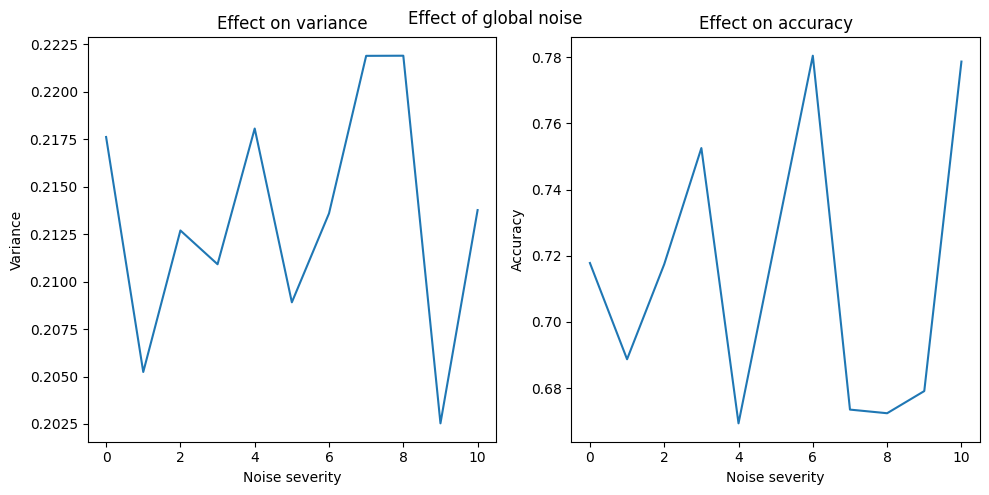

In [43]:
# Load in the two .pkl files
with open('results_pickled/accuracies.pkl', 'rb') as f:
    accuracies = pickle.load(f)

with open('results_pickled/variances.pkl', 'rb') as f:
    variances = pickle.load(f)

# Take the mean of the variances
for i in range(len(variances)):
    variances[i] = np.mean(np.asarray(variances[i]))
    accuracies[i] = np.mean(np.asarray(accuracies[i]))

t = np.asarray([0, 1, 2, 3, 4, 5, 6, 7 ,8, 9, 10])

# Plot the variances of the different levels of noise
figure, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(t, variances)
axes[0].set_xlabel("Noise severity")
axes[0].set_ylabel("Variance")
axes[0].set_title("Effect on variance")
axes[1].plot(t, accuracies)
axes[1].set_xlabel("Noise severity")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Effect on accuracy")

figure.tight_layout()
figure.suptitle("Effect of global noise")
